# Modelo 2 - Predicción de ingresos

## Notebook para probar diferentes configuraciones y obtener el modelo.
Este código lee los datos de ingresos que estan agregados en grupos de 28 días. Tenemos para cada día los ingresos de los 28 días previos. Los datos abarcan desde 2019-01-01 hasta el 2021-05-01.
El planteamiento para el modelo es utiliza los n días previos para calcular los ingresos futuros.

# 0. Configuración

Instalar pycaret si fuese necesario

In [37]:
pip install pycaret

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Importamos las librerías necesarias

In [38]:
from pycaret.regression import *
import os
import datetime
import pandas as pd
S3=client('s3')

Esta variable define la ventana de n días previos a utilizar para predicir el valor actual.

In [39]:
window=27

# 1. Carga de datos

Cargamos el archivo CSV con los datos y parseamos el campo date como fecha.

In [40]:
dataset_raw = pd.read_csv('s3://tfm-2021-darwinex/data/model2/dataset_model2.csv', parse_dates=['date'])
dataset_raw.tail()

,date,commission
702,2021-04-12,286972.497651
703,2021-04-13,285758.616379
704,2021-04-14,284394.750251
705,2021-04-15,282975.681124
706,2021-04-16,281553.564786


<AxesSubplot:xlabel='date'>

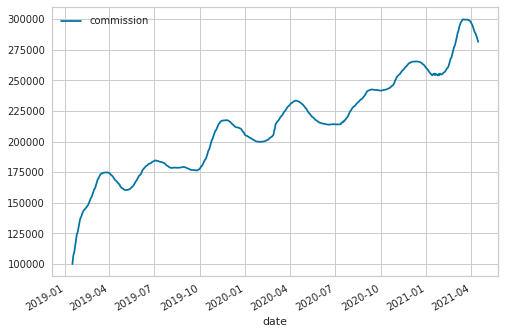

In [41]:
dataset_raw.plot(x='date')

En base a la variable window, montamos el dataset necesario para el entrenamiento, obteniendo para cada día los n dias previos.

In [42]:
for i in range(1, window+1):
    col = 'lag_' + str(i)
    dataset_raw[col] = dataset_raw['commission'].shift(i)

In [43]:
dataset_raw.dropna(inplace=True)
dataset_raw.tail()

,date,commission,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27
702,2021-04-12,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,296838.386489,...,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809,296522.874862
703,2021-04-13,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,...,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809
704,2021-04-14,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,...,299752.379948,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914
705,2021-04-15,282975.681124,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,...,299732.884500,299752.379948,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693
706,2021-04-16,281553.564786,282975.681124,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,...,299514.148056,299732.884500,299752.379948,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000


# 2. Iniciar PyCaret

Inicializamos Pycaret con la función setup.
Tras diversas pruebas hemos utilizado la siguiente configuración:
- normalize = True: Sirve para normalizar cada columna del dataset.
- transformation = True: Aplica las transofrmaciones para que los datos del dataset se ajusten mas a una campana de Gauss
- ignore_features=['date']: Con esto indicamos que no queremos que utilice la columna date
- target='commission': Aquñi indicamos que la variable que queremos predecir con el modelo
- remove_outliers=True
- remove_perfect_collinearity=False


In [44]:
exp_reg101 = setup(data = dataset_raw, normalize = True, ignore_features=['date'], data_split_shuffle=False, target = 'commission', remove_perfect_collinearity=False, silent=True) 

,Description,Value
0,session_id,4428
1,Target,commission
2,Original Data,"(680, 29)"
3,Missing Values,False
4,Numeric Features,27
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(475, 27)"


# 3. Crear el modelo y elegir la mejor opción

Con la función *compare_models* ejecutamos la creación y comparación de los diferentes algoritmos que incluye Pycaret para Regression. Hemos indicado utilizar RMSLE en sort para que ordene la tabla por esta metrica. Consideramos que esta métrica, al ser un valor porcentual permite entender de una manera muy sencilla el tamaño del error. Esta función devuelve el modelo con mejor métrica.

In [45]:
best = compare_models(exclude = ['ransac'], sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,101.6910,46884.0925,168.6661,0.9980,0.0008,0.0005,0.2000
br,Bayesian Ridge,100.8735,46289.7306,167.7837,0.9980,0.0008,0.0005,0.0060
lasso,Lasso Regression,160.1003,66806.5299,221.2466,0.9957,0.0011,0.0008,0.0070
huber,Huber Regressor,163.4722,97140.9880,247.0904,0.9950,0.0013,0.0008,0.0190
llar,Lasso Least Angle Regression,273.5139,150129.4342,355.8739,0.9905,0.0018,0.0014,0.0080
omp,Orthogonal Matching Pursuit,349.8277,224103.0550,439.5545,0.9886,0.0023,0.0018,0.0070
ridge,Ridge Regression,392.5156,340276.6764,512.4262,0.9768,0.0027,0.0021,0.0060
par,Passive Aggressive Regressor,700.9225,1124881.4900,904.1491,0.9490,0.0048,0.0037,0.0190
lightgbm,Light Gradient Boosting Machine,1729.0640,8234174.1562,2405.3565,0.6718,0.0131,0.0093,0.1020
gbr,Gradient Boosting Regressor,2275.7842,12135765.1298,2866.2257,-0.2183,0.0155,0.0124,0.1070


In [46]:
#best = create_model('llar')

# 4. Ajustar hiperparámetros

Utilizando la función *tune_model* hacemos que Pycaret obtenga y optimice los hyperparámetros del algoritmo utilizado. 

In [47]:
best_tuned = tune_model(best)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,143.1292,33928.9141,184.1980,0.9995,0.0012,0.0009
1,70.1494,8197.1982,90.5384,0.9996,0.0005,0.0004
2,80.0332,10348.4336,101.7272,0.9974,0.0006,0.0004
3,66.9121,5881.6860,76.6922,0.9937,0.0004,0.0004
4,77.3490,10253.6826,101.2605,1.0000,0.0005,0.0004
5,92.6662,19225.6484,138.6566,0.9992,0.0007,0.0004
6,169.9279,231781.8125,481.4372,0.9942,0.0023,0.0008
7,84.2550,15221.7432,123.3764,0.9990,0.0005,0.0004
8,19.8321,550.2864,23.4582,1.0000,0.0001,0.0001
9,212.6273,133394.5312,365.2321,0.9974,0.0017,0.0010


# 5. Probar modelo con datos de test

In [48]:
predict_new = predict_model(best_tuned)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,186.1927,157196.7969,396.4805,0.9995,0.0015,0.0007


 # 6. Mostrar información del modelo

Utilizando la función *plot_model* podemos visualizar diferentes métricas o graficas resultantes del modelo.

## 6.1 Area Under the Curve

In [49]:
try:
    plot_model(calibrated_dt, plot='auc')
except Exception as ex:
    print("This model can't measure auc.")

This model can't measure auc.


## 6.1 Area Under the Curve

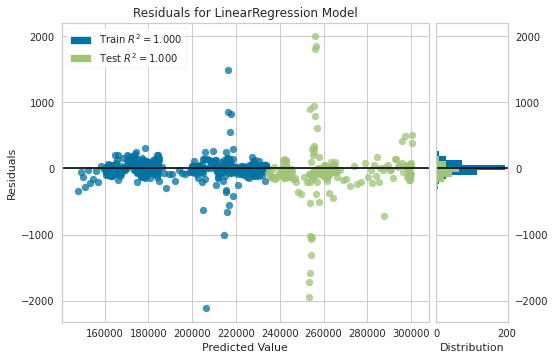

In [50]:
plot_model(best_tuned, plot='residuals')

## 6.1 Area Under the Curve

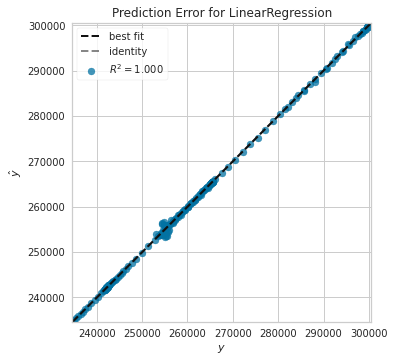

In [51]:
plot_model(best_tuned, plot = 'error')

## 6.1 Area Under the Curve

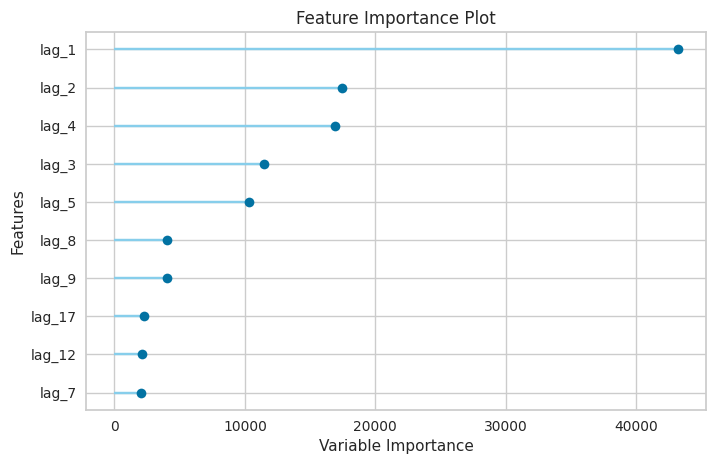

In [52]:
plot_model(best_tuned, plot='feature')

 # 7. Finalizar y comparar el resultado

La función *finalize_model* da por temrminado el ajuste del modelo, utilizando para ello todos los datos del dataset utilizando al inicio, y no solo lo conjunto de entrenamiento.

In [53]:
final_model = finalize_model(best_tuned)

Utilizamos el modelo para calcular, utilizando el dataset original, los datos de cada día para comparar, visualmente, ambas lineas.

In [54]:
test_result = predict_model(final_model, dataset_raw)

In [55]:
test_result

,date,commission,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,Label
27,2019-02-17,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,143895.256153,143170.924226,...,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,103618.241851,100000.000000,147918.078125
28,2019-02-18,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,143895.256153,...,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,103618.241851,149146.718750
29,2019-02-19,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,...,128902.567567,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,150140.515625
30,2019-02-20,151420.824862,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,...,131183.357687,128902.567567,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,151075.531250
31,2019-02-21,152472.959751,151420.824862,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,...,133286.095199,131183.357687,128902.567567,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,152304.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,2021-04-12,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,296838.386489,...,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809,296522.874862,287002.437500
703,2021-04-13,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,...,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809,285760.187500
704,2021-04-14,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,...,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,284564.687500
705,2021-04-15,282975.681124,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,...,299752.379948,299696.666713,299666.743776,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,283155.343750


<AxesSubplot:xlabel='date'>

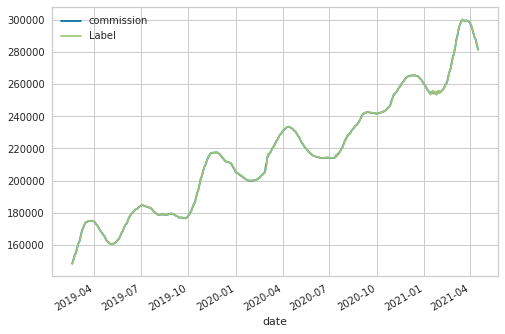

In [56]:
test_result.plot(x='date', y=['commission', 'Label'])

## 8. Guardar modelo

In [57]:
save_model(final_model, model_name='model2', verbose=False)
S3.upload_file('model2.pkl', 'tfm-2021-darwinex', 'models/model2/final_model.pkl')
S3.upload_file('model2.pkl', 'tfm-2021-darwinex', 'models/model2/history/{}_model'.format(datetime.datetime.now()))

# 9. Predecimos dias futuros

In [58]:
df = test_result
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)

df['prediction'] = df['commission']
df['calculated'] = 0

dates_to_predict = pd.DataFrame(pd.date_range(start='2021-03-01', periods=180), columns=['date'])

columns = ['lag_' + str(i) for i in range(1, window+1)]
columns.reverse()

In [59]:
df

,date,commission,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,Label,prediction,calculated
date,,,,,,,,,,,,,,,,,,,,,
2019-02-17,2019-02-17,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,143895.256153,143170.924226,...,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,103618.241851,100000.000000,147918.078125,148394.510378,0
2019-02-18,2019-02-18,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,143895.256153,...,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,103618.241851,149146.718750,149344.843504,0
2019-02-19,2019-02-19,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,144610.241986,...,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,107010.720018,150140.515625,150325.859191,0
2019-02-20,2019-02-20,151420.824862,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,145266.981897,...,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,110127.401465,151075.531250,151420.824862,0
2019-02-21,2019-02-21,152472.959751,151420.824862,150325.859191,149344.843504,148394.510378,147406.611720,146688.142986,146175.122106,145747.171624,...,128902.567567,126628.648569,124185.171231,121518.786440,118670.868615,115916.384413,113058.144967,152304.625000,152472.959751,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-12,2021-04-12,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,296838.386489,...,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809,296522.874862,287002.437500,286972.497651,0
2021-04-13,2021-04-13,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,295596.039373,...,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,297608.833809,285760.187500,285758.616379,0
2021-04-14,2021-04-14,284394.750251,285758.616379,286972.497651,288187.058198,289457.120653,290647.615956,291791.882306,292960.251953,294281.562066,...,299684.757233,299775.240665,299806.903572,299884.261231,300000.000000,299641.480693,298736.752914,284564.687500,284394.750251,0


In [60]:
for row in dates_to_predict.iterrows():
    if row[1][0].weekday() != 5:
        df_temp = df[df.index < row[1][0]].tail(n=window).transpose().iloc[[window+3]]
        df_temp.columns = columns
        prediction = predict_model(final_model, df_temp).iloc[0]['Label']
        new_row = pd.DataFrame({'prediction': prediction, 'calculated': 1}, index=[row[1][0]])
        if not df[df.index.isin([row[1][0]])].empty:
            df.update(new_row)
        else:
            df = df.append(new_row)
        df.sort_index(inplace=True)

In [61]:
df.tail(100)

,date,commission,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,Label,prediction,calculated
2021-05-04,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285405.84375,1.0
2021-05-05,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284863.56250,1.0
2021-05-06,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284338.46875,1.0
2021-05-07,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283831.43750,1.0
2021-05-09,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283342.90625,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270426.68750,1.0
2021-08-24,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270295.18750,1.0
2021-08-25,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270165.09375,1.0
2021-08-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270036.46875,1.0


<AxesSubplot:>

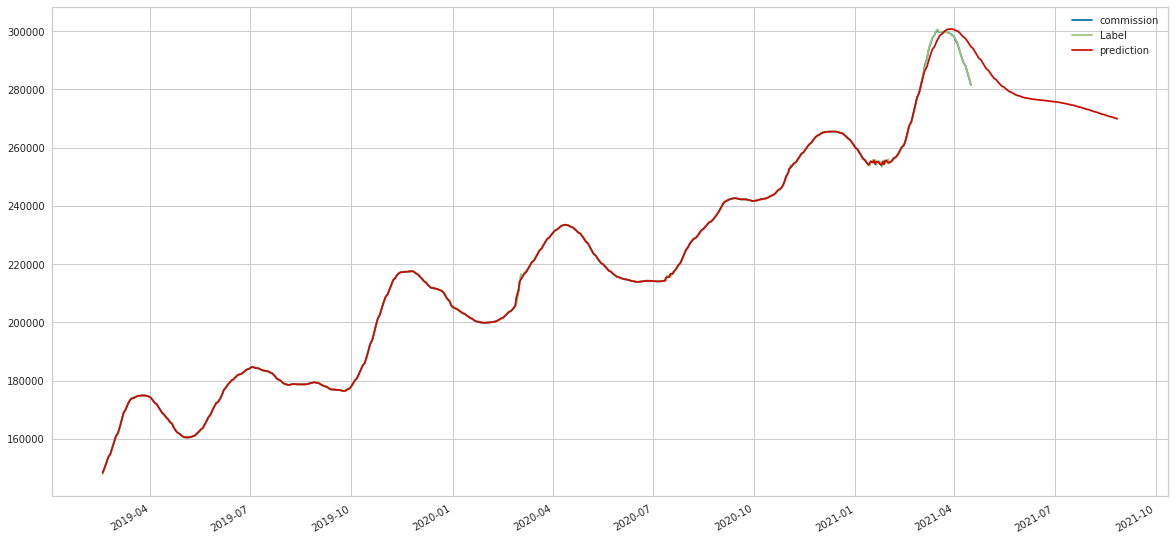

In [62]:
df.plot(y=['commission', 'Label', 'prediction'], figsize=(20,10))